# Моделирование синтетических транзакционных данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl
%pylab inline
figsize(12, 9)
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
from matplotlib import rc
font = {'weight': 'normal', 'size': 16}
rc('font', **font)
from tqdm import tnrange, tqdm_notebook, tqdm
from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget
import os
import sys
import artm
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import dash
import dash_core_components as dcc
import dash_html_components as html
import base64
import datetime
import io
from dash.dependencies import Input, Output
from sklearn.manifold import MDS
from scipy.stats import wasserstein_distance

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

Использованная в задании выборка была получена в результате работы симулятора банковских транзакций BankSim. Подробнее о данной системе можно прочитать в статье <a href="https://www.researchgate.net/publication/265736405_BankSim_A_Bank_Payment_Simulation_for_Fraud_Detection_Research" target="_blank">BankSim: A Bank Payment Simulation for Fraud Detection Research</a>. Выборка доступна по <a href="https://www.kaggle.com/ntnu-testimon/banksim1/downloads/synthetic-data-from-a-financial-payment-system.zip/1" target="_blank"> ссылке </a>. BankSim представляет собой мультиагентный симулятор банковских транзакций, основанный на примере агрегированных транзакционных данных, представленных существующим банком. Основное предназначение BankSim состоит в порождении синтетических данных для исследования в области распознавания мошенничества.

В следующем файле содержится выборка из 594643 транзакций:

In [2]:
transactions = pd.read_csv('bs140513_032310.csv')

Каждая транзакция описывается следующим набором переменных: 
* <b>step</b> &mdash; описывает номер дня симуляции;
* <b>customer</b> &mdash; кодовое имя клиента;
* <b>age</b> &mdash; возрастная категория клиента;
* <b>gender</b> &mdash; пол клиента;
* <b>zipcodeOri</b> &mdash; почтовый код клиента;
* <b>merchant</b> &mdash; кодовое имя мерчанта;
* <b>zipMerchant</b> &mdash; почтовый код мерчанта;
* <b>category</b> &mdash; категория транзакции, аналог MCC;
* <b>amount</b> &mdash; объём транзакции в условных единицах;
* <b>fraud</b> &mdash; индикатор мошеннической транзакции (0 &mdash; обычная транзакция, 1 &mdash; мошенническая транзакция)

In [3]:
transactions.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


Дополнительная информация о выборке:

In [4]:
pd.DataFrame({'Число транзакций': [transactions.shape[0]],
              'Временной промежуток записи в днях': [transactions.step.unique().shape[0]],
              'Количество клиентов': [transactions.customer.unique().shape[0]],
              'zipcode в транзакциях': [transactions.zipcodeOri.unique()[0]],
              'Количество мерчантов': [transactions.merchant.unique().shape[0]],
              'Количество категорий транзакций': [transactions.category.unique().shape[0]],
              'Число значений поля gender': [transactions.gender.unique().shape[0]],
              'Число значений категории возраст': [transactions.age.unique().shape[0]]
             }, index=['значение']).T

,значение
zipcode в транзакциях,'28007'
Временной промежуток записи в днях,180
Количество категорий транзакций,15
Количество клиентов,4112
Количество мерчантов,50
Число значений категории возраст,8
Число значений поля gender,4
Число транзакций,594643


В рамках тематического моделирования транзакции одного клиента формируют один документ:

In [5]:
grouped_transactions = transactions.groupby('customer')

Вводится соответствие между клиентом и числом совершённых им транзакций:

In [6]:
customers_trans_num = {}
for customer, indexer in grouped_transactions.groups.items():
    customers_trans_num[customer] = indexer.shape[0]

За 180 дней среднее число совершённых транзакций у клиента близко к 145:

In [10]:
np.mean(list(customers_trans_num.values()))

144.61162451361866

Выявление распределения количества транзакций у клиента в выборке:

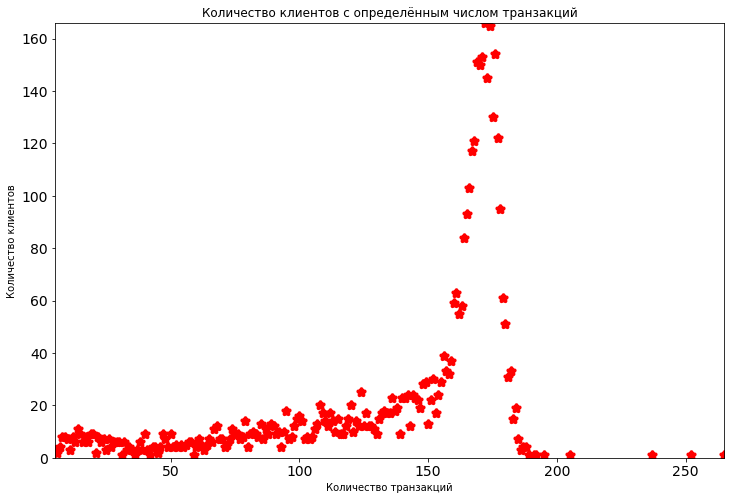

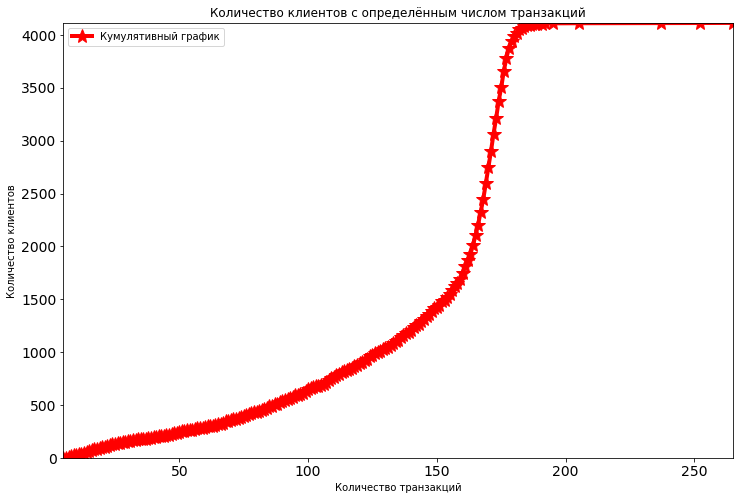

In [7]:
plt.figure(figsize=(12, 8))
plt.title('Количество клиентов с определённым числом транзакций')
plt.xlabel(r'Количество транзакций')
plt.ylabel(r'Количество клиентов')
plt.axis([5, 265, 0, 166])
x, y = np.unique(list(customers_trans_num.values()), return_counts=True)
plt.scatter(x, y, c='red', linewidth=4, marker='*', s=44)
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(12, 8))
plt.title('Количество клиентов с определённым числом транзакций')
plt.xlabel(r'Количество транзакций')
plt.ylabel(r'Количество клиентов')
plt.axis([5, 265, 3, 4112])
plt.plot(x, y.cumsum(), c='red', label=r'Кумулятивный график',linewidth=4, marker='*', markersize=14)
plt.legend(loc=2)
plt.show()

Вводится соответствие между категорией транзакции и индексом для подготовки выборки к моделированию:

In [8]:
category_mapping = {}
transactions_category = transactions.category.unique()
for idx, cat in enumerate(np.sort(transactions_category)):
    category_mapping[cat] = idx

Вводится соответствие между клиентом и индексом для подготовки выборки к моделированию:

In [9]:
customer_mapping = {}
transactions_customer = transactions.customer.unique()
for idx, customer in enumerate(np.sort(transactions_customer)):
    customer_mapping[customer] = idx

Подготовка матрицы токены-документы:

In [10]:
category_num = transactions_category.shape[0]
customer_num = transactions_customer.shape[0]

Категории транзакций в модели являются токенами:

In [11]:
cat_cus_matrix = np.zeros((category_num, customer_num), dtype=np.int64)
for row in transactions.index:
    cat_cus_matrix[category_mapping[transactions.loc[row, 'category']],
                   customer_mapping[transactions.loc[row, 'customer']]] += 1

Подготовка словаря выборки для инициализации bigARTM:

In [12]:
vocabulary = {}
for key, val in category_mapping.items():
    vocabulary[val] = key

Разделение матрицы токены-документы на подвыборки для настройки тематической модели:

In [13]:
bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=cat_cus_matrix,
                          vocabulary=vocabulary)

Количество предметных и фоновых тем было определено с помощью процедуры кросс-валидации на сетке из возможных значений количества предметных и фоновых тем с отложенной выборкой, составляющей 35% от всего объёма выборки. При фиксированном количестве тем в результате аналогичной процедуры кросс-валидации были определены коэффициенты при выбранных заранее регуляризаторах. Качество модели в процедуре кросс-валидации оценивалось по перплексии:

In [14]:
num_topics = 10
num_back = 4
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]
model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=bv.dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='ThetaRegularizer', tau=-0.1),
                                     artm.SmoothSparsePhiRegularizer(name='PhiRegularizerSparse', tau=-10.5,
                                                                     topic_names=[\
                                          'topic_{}'.format(i) for i in range(num_topics - num_back)]),
                                     artm.SmoothSparsePhiRegularizer(name='PhiRegularizerSmooth', tau=0.5,
                                                                     topic_names=[\
                                          'topic_{}'.format(i) for i in range(num_topics - num_back, num_topics)]),
                                     artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiSubject', tau=3000,
                                                                     topic_names=[\
                                          'topic_{}'.format(i) for i in range(num_topics - num_back)]),
                                     artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiBackground', tau=3000,
                                                                     topic_names=[\
                                          'topic_{}'.format(i) for i in range(num_topics - num_back, num_topics)])])

Инициализация модели и настройка параметров BigARTM:

In [15]:
model_artm.initialize(dictionary=bv.dictionary)
model_artm.fit_offline(bv, num_collection_passes=60)

Настроенная матрица токены-темы:

In [16]:
model_artm.get_phi()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
'es_otherservices',0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000006,0.000191,0.244352,0.000098
'es_transportation',0.941652,1.0,0.0,0.902523,0.891067,0.0,0.782655,0.000158,0.000174,0.000168
'es_contents',0.000000,0.0,0.0,0.000000,0.009726,0.0,0.000064,0.000182,0.000270,0.000134
'es_hyper',0.000000,0.0,1.0,0.000000,0.000000,0.0,0.000014,0.000488,0.000699,0.000262
'es_barsandrestaurants',0.000000,0.0,0.0,0.065590,0.000000,0.0,0.000009,0.012670,0.009304,0.000400
'es_wellnessandbeauty',0.038280,0.0,0.0,0.023292,0.000000,0.0,0.000119,0.000152,0.000157,0.996508
'es_leisure',0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000005,0.000317,0.133501,0.000088
'es_hotelservices',0.000000,0.0,0.0,0.008595,0.000000,0.0,0.000104,0.000474,0.240205,0.000288
'es_home',0.014415,0.0,0.0,0.000000,0.000000,0.0,0.000034,0.000480,0.141529,0.000186
'es_tech',0.000000,0.0,0.0,0.000000,0.025111,0.0,0.000034,0.000740,0.031524,0.000174


Среди тем есть темы, представленные только одним токеном: **topic_1** представляет операции по переводу денежных средств (*es_transportation*), **topic_2** представляет оплаты в гипермаркетах (*es_hyper*), **topic_5** представляет оплаты услуг, связанных со здравоохранением (*es_health*).  
В темах **topic_0**, **topic_3**, **topic_4** наблюдается доминирование операций по переводу денежных средств с небольшой долей других операций.  
В фоновых темах распределение токенов менее вырожденное. Но данные темы также можно проинтерпретировать. **topic_6** является смесью с доминированием операций по переводу денег и по оплате еды (*es_transportation*, *es_food*). **topic_7** состоит из львиной доли покупок в спортивных магазинах, в магазинах игрушек, в магазинах одежды (*es_sportsandtoys*, *es_fashion*). Тема **topic_8** является наиболее близкой к равномерному распределению, которая может описывать покупки, совершённые в путешествии (*es_otherservices*, *es_leisure*, *es_hotelservices*, *es_home*, *es_travel*). **topic_9** состоит из смеси операций с преобладанием операций по оплате услуг в салонах красоты (*es_wellnessandbeauty*):

In [18]:
ptdw_df = model_artm.transform(batch_vectorizer=bv, theta_matrix_type='dense_ptdw')
ptdw_tensor = np.zeros((model_artm.num_topics, cat_cus_matrix.shape[1], cat_cus_matrix.shape[0]), dtype=np.float64)
for doc_idx in range(cat_cus_matrix.shape[1]):
    for i in range(model_artm.num_topics):
        ptdw_tensor[i, doc_idx, np.where(cat_cus_matrix[:, doc_idx] > 0)[0]] = ptdw_df.loc['topic_{}'.format(i),\
                                                                                           doc_idx].as_matrix()

Параметры настроенной модели записываются в исходную выборку:

In [ ]:
phi_df = model_artm.get_phi()
theta_df = model_artm.get_theta()

topic_transactions_dict = {'step': np.zeros(transactions.shape[0], dtype=np.int64),
                           'customer': ["0"*11 for _ in range(transactions.shape[0])],
                           'category': ["0"*11 for _ in range(transactions.shape[0])],
                           'gender': ["0" for _ in range(transactions.shape[0])],
                           'age': ["0" for _ in range(transactions.shape[0])],
                           'merchant': ["0"*11 for _ in range(transactions.shape[0])],
                           'fraud': np.zeros(transactions.shape[0], dtype=np.int64),
                           'amount': np.zeros(transactions.shape[0], dtype=np.float64)}
for i in range(model_artm.num_topics):
    topic_transactions_dict['t_%i|dw'%i] = np.zeros(transactions.shape[0], dtype=np.float64)
    topic_transactions_dict['t_%i|d'%i] = np.zeros(transactions.shape[0], dtype=np.float64)
    topic_transactions_dict['w|t_%i'%i] = np.zeros(transactions.shape[0], dtype=np.float64)
topic_transactions = pd.DataFrame(topic_transactions_dict)
del topic_transactions_dict

for row_idx in tqdm(range(transactions.shape[0]), desc='transactions'):
    topic_transactions.loc[row_idx, 'category'] = transactions.loc[row_idx, 'category']
    topic_transactions.loc[row_idx, 'customer'] = transactions.loc[row_idx, 'customer']
    topic_transactions.loc[row_idx, 'step'] = transactions.loc[row_idx, 'step']
    topic_transactions.loc[row_idx, 'gender'] = transactions.loc[row_idx, 'gender']
    topic_transactions.loc[row_idx, 'age'] = transactions.loc[row_idx, 'age']
    topic_transactions.loc[row_idx, 'merchant'] = transactions.loc[row_idx, 'merchant']
    topic_transactions.loc[row_idx, 'fraud'] = transactions.loc[row_idx, 'fraud']
    topic_transactions.loc[row_idx, 'amount'] = transactions.loc[row_idx, 'amount']
    for i in range(model_artm.num_topics):
        topic_transactions.loc[row_idx, 't_%i|dw'%i] = ptdw_tensor[i,
                                                           customer_mapping[transactions.loc[row_idx, 'customer']],
                                                           category_mapping[transactions.loc[row_idx, 'category']]]
        topic_transactions.loc[row_idx, 't_%i|d'%i] = theta_df.loc['topic_%i'%i,
                                                           customer_mapping[transactions.loc[row_idx, 'customer']]]
        topic_transactions.loc[row_idx, 'w|t_%i'%i] = phi_df.loc[transactions.loc[row_idx, 'category'],
                                                                 'topic_%i'%i]

transactions:  68%|██████▊   | 406348/594643 [19:08:31<8:52:12,  5.90it/s] 

Сохранение изменённой выборки в файл:

In [ ]:
topic_transactions.to_csv('bs140513_032310_topic.csv', index=False)

Загрузка изменённой выборки в оперативную память:

In [19]:
topic_transactions = pd.read_csv('bs140513_032310_topic.csv')

Разделение изменённой выборки по клиентам для последующей визуализации:

In [20]:
grouped_topic_transactions = topic_transactions.groupby('customer').apply(\
                             lambda x: x.sort_values(['step'])).reset_index(drop=True).groupby('customer')

Сохранение полученных подвыборок в файлы для визуализации операций каждого клиента в отдельности:

In [21]:
for customer, _ in grouped_topic_transactions.groups.items():
    grouped_topic_transactions.get_group(customer).to_csv('./documents/%s.csv'%customer, index=False)